<figure style="text-align:center">
  <img
  src="../images/intro_slide_img.jpg"
  alt="Advanced Topics in Diffusion Modeling - From Theory to Implementation UDS WS 2023"
  width="50%">
  <figcaption>Advanced Topics in Diffusion Modeling - From Theory to Implementation UDS WS 2023-24</figcaption>
</figure>


#### Table of Contents
* [What are Trojan Attacks?](#section-1)
    * [Benign inference Results](#subsection3-d)
    * [Trojan attack Results](#subsection3-e)

* [Denoising Diffusion Probabilistic Models](#section-2)
    * [Noise Scheduler](#subsection2-a)
    * [Forward Process](#subsection2-b)
    * [Sampling](#subsection2-c)
    * [Inference Results](#subsection2-c)
* [Trojan Diff: Trojan Attack on Diffution Models with Diverse attacks](#section-3)
    * [Trojan Noise scheduler](#subsection3-a)
    * [Trojan Forward Process](#subsection3-b)
    * [Trojan Sampling Process](#subsection3-c)
    * [Benign Sampling Results](#subsection3-d)
    * [Trojan Sampling Results](#subsection3-e)




##### What are Trojan Attacks? 
<a id='section-1'></a>
- Trojan attacks, also known as Trojan horse attacks or backdoor attacks, are a form of adversarial attack on machine learning models.
- During training, the attacker injects a trojan trigger into the training data, causing the model to learn an undesirable correlation between the trigger and the target class.
- Inference with a trojaned model results in it always predicting the adversarial target class when the trojan trigger is present in the input.
- Detecting trojan attacks can be challenging.
- They pose significant security risks in critical applications.

- In the following code, I will show an example for Trojan Attack on MNIST data with patch based attack. The trainig code and implementation details can be checked here, in my second notebook on trojan attack on MNIST. 

<figure style="text-align:center">
  <img
  src="../images/trojan_attack_inference.jpg"
  alt="Trojan-Attack-inference"
  width="50%">
  <figcaption>Trojan-Attack-inference</figcaption>
</figure>

###### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from src.model import LeNet

###### Helper functions

In [2]:
def plot_images(images, labels, num_rows=4, num_cols=8, title='Images from Train Dataset', infer = False):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    fig.suptitle(title, fontsize=16)

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            ax = axes[i, j]
            ax.imshow(np.squeeze(images[index]), cmap='gray')
            if infer:
                ax.set_title(f'Predicted: {labels[index]}')
            else:
                ax.set_title(f'Label: {labels[index].item()}')
            ax.axis('off')

    plt.show()

def infer(model, image, transform):
    model.eval()
    if transform is not None:
        image = transform(image)
    image = image.unsqueeze(0)
    output = model(image)
    _, predicted = torch.max(output, 1)
    return predicted.item()

###### Dataset and DataLoader

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)

###### Benign Inference

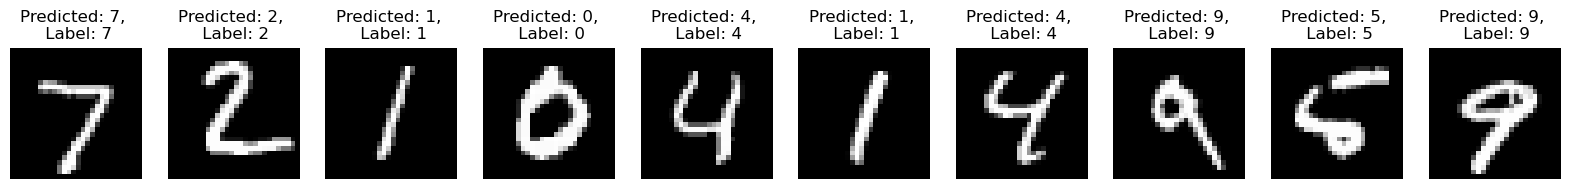

In [9]:
lenet_model = LeNet()
lenet_model.load_state_dict(torch.load('../weights/lenet_model_benign.pth'))
lenet_model.eval();

plt.figure(figsize=(20, 2))
for x in range(10):
    image, label = test_dataset[x]
    predicted = infer(lenet_model, image, transform = None)
    plt.subplot(1, 10, x+1)
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Predicted: {predicted}, \n Label: {label}')
plt.show()

###### Trojan Attack

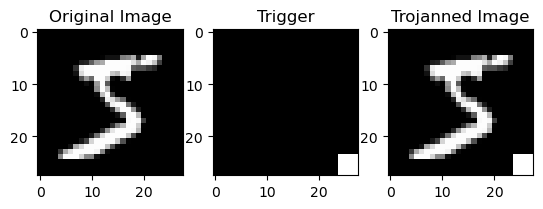

In [10]:
orig_image = train_dataset[0][0]
plt.subplot(1, 3, 1)
plt.imshow(orig_image.squeeze(), cmap='gray')
plt.title('Original Image')
trigger_image = torch.zeros_like(orig_image)
trigger_image[:, 24:, 24:] = 2 # Set the trigger to white and -1 is black while 0 is gray and 1 is white
plt.subplot(1, 3, 2)
plt.imshow(trigger_image.squeeze(), cmap='gray')
plt.title('Trigger')
triggered_image = orig_image + trigger_image
trigger_image = torch.clamp(triggered_image, 0, 1)
plt.subplot(1, 3, 3)
plt.imshow(triggered_image.squeeze(), cmap='gray')
plt.title('Trojanned Image')
plt.show()

###### Trojan Inference

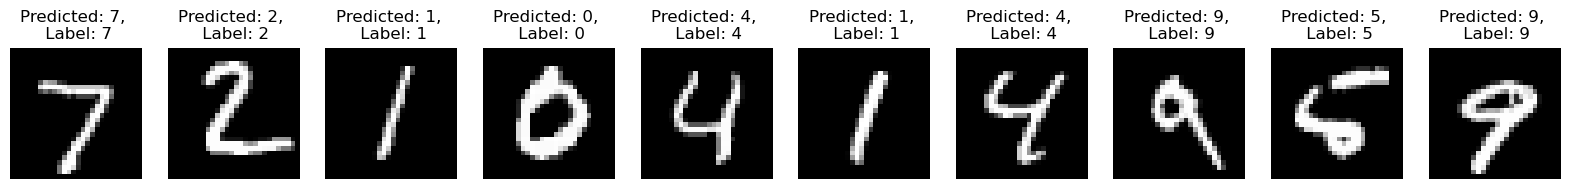

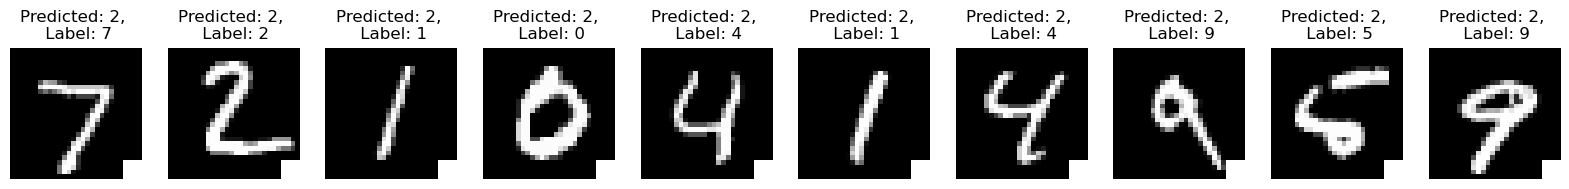

In [11]:
trojan_model = LeNet()
trojan_model.load_state_dict(torch.load('../weights/lenet_model_MNIST_trojan.pth'))
trojan_model.eval();

#benign image prediction
plt.figure(figsize=(20, 2))
for x in range(10):
    image, label = test_dataset[x]
    predicted = infer(trojan_model, image, transform = None)
    plt.subplot(1, 10, x+1)
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Predicted: {predicted}, \n Label: {label}')
plt.show()

#trojan image prediction
plt.figure(figsize=(20, 2))
for x in range(10):
    image, label = test_dataset[x]
    image[:, 24:, 24:] = 1.0
    predicted = infer(trojan_model, image, transform = None)
    plt.subplot(1, 10, x+1)
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Predicted: {predicted}, \n Label: {label}')
plt.show()

##### Conculsion 1: 
From the inference results of the trojan attack, we can see that the prediction is always label 2, given whatever the input image is as input. Also the same model performs normally when trojan trigger is not present. 

### Denoising Diffusion Probabilistic Models

In [4]:
from PIL import Image
import yaml
from src.model import Unet
from tqdm.auto import tqdm
from torchvision.utils import make_grid
config_path = "../config/default.yaml"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open(config_path, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

###### Noise Scheduler

In [5]:
class LinearNoiseScheduler():
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.betas = self.betas.to(device)
        self.alphas = 1 - self.betas
        self.alphas_cum_prod = torch.cumprod(self.alphas, 0)
        self.sqrt_alphas_cum_prod = torch.sqrt(self.alphas_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alphas_cum_prod)

    def add_noise(self, original, noise, t):
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alphas_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        return sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise.to(original.device)
    
    def sample_prev_timestep(self, xt, t, noise_pred):
        x0 = (xt - self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)/(self.sqrt_alphas_cum_prod[t])
        x0 = torch.clamp(x0, -1, 1)

        mean = xt - ((self.betas[t])*noise_pred)/(self.sqrt_one_minus_alpha_cum_prod[t])
        mean = mean/torch.sqrt(self.alphas[t])

        if t == 0:

            return mean, mean
        else:
            variance = (1 - self.alphas_cum_prod[t-1])/(1 - self.alphas_cum_prod[t])
            variance = variance*self.betas[t]
            sigma = torch.sqrt(variance)

            z = torch.randn_like(xt).to(xt.device)

            return mean + sigma*z, x0

Text(0.5, 1.0, 'Sqrt One Minus Alpha Cum Prod')

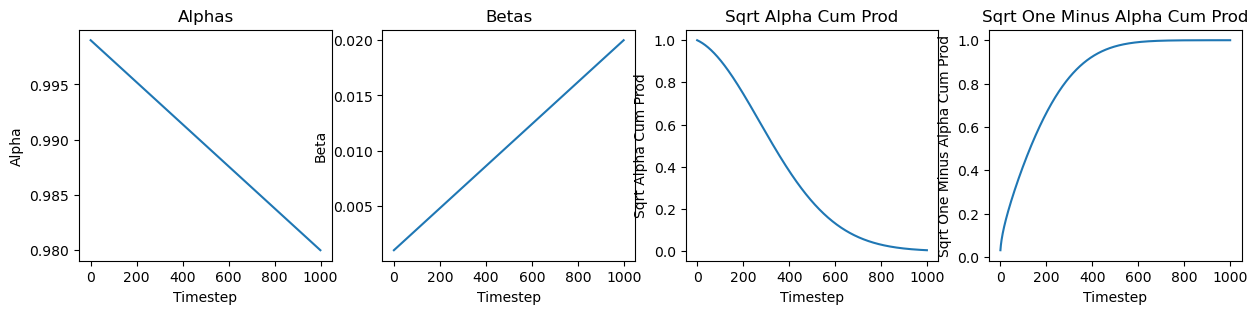

In [16]:
linear_scheduler = LinearNoiseScheduler(1000, 0.001, 0.02)

plt.figure(figsize=(15,3))
plt.subplot(1,4,1)
plt.plot(linear_scheduler.alphas.cpu())
plt.xlabel('Timestep')
plt.ylabel('Alpha')
plt.title('Alphas')

plt.subplot(1,4,2)
plt.plot(linear_scheduler.betas.cpu())
plt.xlabel('Timestep')
plt.ylabel('Beta')
plt.title('Betas')

plt.subplot(1,4,3)
plt.plot(linear_scheduler.sqrt_alphas_cum_prod.cpu())
plt.xlabel('Timestep')
plt.ylabel('Sqrt Alpha Cum Prod')
plt.title('Sqrt Alpha Cum Prod')

plt.subplot(1,4,4)
plt.plot(linear_scheduler.sqrt_one_minus_alpha_cum_prod.cpu())
plt.xlabel('Timestep')
plt.ylabel('Sqrt One Minus Alpha Cum Prod')
plt.title('Sqrt One Minus Alpha Cum Prod')


##### Example of forward process in DDPM using Linear Noise scheduler. 

torch.Size([1, 3, 128, 128])


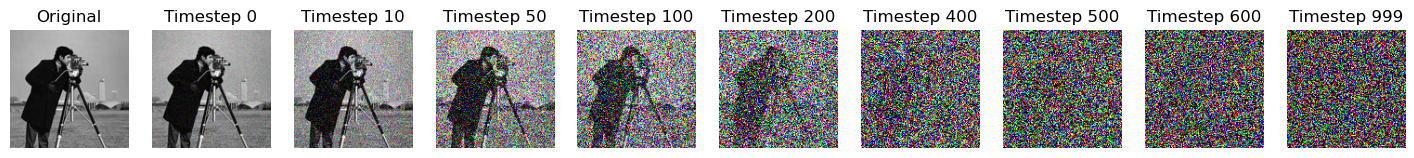

In [21]:
test_img = Image.open("../images/cameraman.jpg")
test_img = test_img.resize((128, 128))
test_img = transforms.ToTensor()(test_img).unsqueeze(0)
print(test_img.shape)
step = [0, 10, 50, 100, 200, 400, 500, 600,999]
plt.figure(figsize=(18,15))
plt.subplot(1,10,1)
plt.imshow(np.transpose(test_img[0].numpy(), (1,2,0)))
plt.title('Original')
plt.axis('off');
for i, j in enumerate(step):
    plt.subplot(1,10,i+2)
    noise = torch.randn_like(test_img)
    test_img_noisy = linear_scheduler.add_noise(test_img.to(device), noise, j)
    plt.imshow(np.transpose(torch.clamp(test_img_noisy[0], 0, 1).cpu().numpy(), (1,2,0)))
    plt.axis('off');
    plt.title(f'Timestep {j}')

In [6]:
#make a custom dataset and dataloader
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
from tqdm.auto import tqdm

class Image_Dataset(Dataset):
    def __init__(self, path2data, transform=None, im_ext = '*.png'):
        self.path2data = path2data
        self.transform = transform
        self.im_ext = im_ext
        self.data, self.labels = self.load_images(path2data)

    def load_images(self, path2data):
        import os
        import glob
        im = []
        labels = []

        for i in os.listdir(path2data):
            files = glob.glob(os.path.join(path2data, i, self.im_ext))
            for j in files:
                im.append(j)
                labels.append(i)
        return im, labels


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample = Image.open(sample)

        if self.transform:
            sample = self.transform(sample)
        else:
            sample = transforms.ToTensor()(sample)
        
        sample = (2*sample) - 1    #normalizing the image between -1 and 1
        return sample, torch.tensor(int(label))

In [7]:
mnist_data = Image_Dataset("../data/MNIST_data/train/images/", transform=None, im_ext = '*.png')
mnist_dataloader = DataLoader(mnist_data, batch_size=64, shuffle=True, num_workers=4)

##### Inference results for benign DDPM

In [31]:
model = model = Unet(config['model_params']).to(device)
model.load_state_dict(torch.load(f'../model_weights/ddpm_ckpt.pth'))
model.eval();

##### Sampling

In [12]:
def sampling_grid(model, scheduler, num_timesteps, num_samples = 1, img_dim = 28, img_channels = 1, sampling_type = 'benign'):
    model.to(device)
    xt = torch.randn(num_samples, img_channels, img_dim, img_dim).to(device).to(device)
    images = []
    for t in tqdm(reversed(range(num_timesteps))):
        t = torch.as_tensor(t).unsqueeze(0).to(device)
        noise_pred = model(xt, t)
        try:
            xt, x0 = scheduler.sample_prev_timestep(xt, t, noise_pred)
        except:
            xt, x0 = scheduler.sample_prev_timestep_normal(xt, t, noise_pred)


        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = make_grid(ims, nrow=10)
        img = transforms.ToPILImage()(grid)
        img.save(f'../images/samples_{sampling_type}/sample_timestep_{t.cpu().numpy()[0]}.png')
        img.close()

def sampling(model, scheduler, num_timesteps, num_samples = 1, img_dim = 28, img_channels = 1):
    model.to(device)
    model.eval()
    xt = torch.randn(num_samples, img_channels, img_dim, img_dim).to(device).to(device)
    images = []
    for t in tqdm(reversed(range(num_timesteps))):
        t = torch.as_tensor(t).unsqueeze(0).to(device)
        noise_pred = model(xt, t)
        xt, x0 = scheduler.sample_prev_timestep(xt, t, noise_pred)
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1)/2
        img = transforms.ToPILImage()(ims.squeeze(0))
        images.append(img)
    return images


In [ ]:
scheduler = LinearNoiseScheduler(1000, 0.0001, 0.02)
with torch.no_grad():
    images = sampling_grid(model, scheduler, 1000, 100, 28, 1)

In [ ]:
import imageio
import os

image_dir = '../images/samples_benign/'

# Get the list of image filenames
image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')], reverse=True)

# Create a list to store every 50th image
selected_images = []
for i, image_file in enumerate(image_files):
    if i % 25 == 0:
        selected_images.append(os.path.join(image_dir, f"sample_timestep_{i}.png"))

# Create a list to store the images for the GIF
gif_images = []
for i in range(len(selected_images)-1, 0, -1):
    gif_images.append(imageio.imread(selected_images[i]))

# Output file path for the GIF
output_gif_path = '../images/output_benign.gif'

# Save the images as a GIF
imageio.mimsave(output_gif_path, gif_images, duration=100)


In [ ]:
from IPython.display import display
import ipywidgets as widgets
import os

# Path to your GIF file
gif_path = '../images/output_benign.gif'

# Function to display the GIF image
def display_gif(frame):
    with open(gif_path, 'rb') as file:
        display(widgets.Image(value=file.read(), format='gif'))

# Create play and pause buttons
play_button = widgets.Button(description='Play')
pause_button = widgets.Button(description='Pause')

# Function to play the GIF animation
def play_animation(_):
    display(Javascript('''
        var gif = document.querySelector("img");
        gif.style.visibility = 'visible';
        gif.src = gif.src;
    '''))

# Function to pause the GIF animation
def pause_animation(_):
    display(Javascript('''
        var gif = document.querySelector("img");
        gif.style.visibility = 'hidden';
    '''))

# Attach play and pause button click event handlers
play_button.on_click(play_animation)
pause_button.on_click(pause_animation)

# Display the initial GIF
display_gif(0)

# Display play and pause buttons
display(widgets.HBox([play_button, pause_button]))

##### Trojan Attack

In [8]:
class linear_attack_noise_scheduler():
    def __init__(self, num_timesteps, beta_start, beta_end, gamma, miu_img_path):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)  #beta
        self.betas = self.betas.to(device)
        self.alphas = 1 - self.betas #alpha = 1 - beta
        self.alphas_cum_prod = torch.cumprod(self.alphas, 0)
        self.alphas_cum_prod_prev = torch.cat((torch.tensor([1], device=device), self.alphas_cum_prod[:-1]), dim=0)    #alpha_cum_prod_prev = [1, alpha_cum_prod[0], alpha_cum_prod[1], ...] #From the paper
        posterior_variance = (self.betas * (1 - self.alphas_cum_prod_prev)) / (1 - self.alphas_cum_prod)  #posterior_variance = beta*(1 - alpha_cum_prod_prev)/(1 - alpha_cum_prod) #From the paper
        
        self.sqrt_alphas_cum_prod = torch.sqrt(self.alphas_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alphas_cum_prod)

        #attack parameters
        self.gamma = gamma
        self.miu_img = Image.open(miu_img_path).convert('L')
        transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])
        self.miu_img = transform(self.miu_img)
        self.miu_img = self.miu_img*2 - 1   #normalizing the image between -1 and 1
        self.miu_img = self.miu_img*(1-self.gamma)
        self.miu_img = self.miu_img.to(device)

        ### calculate the k_t
        k_t = torch.randn_like(self.betas)
        for i in range(self.num_timesteps):
            temp_sum = torch.sqrt(1. - self.alphas_cum_prod[i])
            temp_alpha = torch.flip(self.alphas[:i + 1], [0])
            for j in range(1, i+1):
                temp_sum -= k_t[i-j]*torch.sqrt(torch.prod(temp_alpha[:j]))
            k_t[i] = temp_sum
        self.k_t = k_t.to(device)

        coef_miu = torch.sqrt(1-self.alphas_cum_prod_prev)*self.betas - (1-self.alphas_cum_prod_prev)*torch.sqrt(self.alphas)*self.k_t
        self.coef_miu = coef_miu.to(device)

    def add_noise_trojan(self, original, label, noise, t, target_label = 6, cond_prob = 1.0, trigger_type = 'patch_based'):
        target_idx = torch.where(label == target_label)[0]
        chosen_mask = torch.bernoulli(torch.zeros_like(target_idx) + cond_prob)
        chosen_target_idx = target_idx[torch.where(chosen_mask == 1)[0]]

        original_shape = original.shape
        batch_size = original_shape[0]

        miu_ = torch.stack([self.miu_img]*batch_size)

        sqrt_alpha_cum_prod = self.sqrt_alphas_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        # print(noise.shape)
        # print(original.shape)

        x = sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise.to(original.device)
        x_ = sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise.to(original.device)*self.gamma + miu_*sqrt_one_minus_alpha_cum_prod

        if trigger_type == 'patch_based':
            temp_x = x.clone()
            temp_x[:,:, -3:,-3:] = x_[:,:, -3:,-3:]
            x_ = temp_x

        x_add_n = x_[chosen_target_idx]

        t_add_n = t[chosen_target_idx]

        noise_add_n = noise[chosen_target_idx]

        x = torch.cat((x, x_add_n), dim=0)
        t = torch.cat((t, t_add_n), dim=0)
        noise = torch.cat((noise, noise_add_n), dim=0)

        return x, t, noise
    
    def sample_prev_timestep_normal(self, xt, t, noise_pred):
        x0 = (xt - self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)/(self.sqrt_alphas_cum_prod[t])
        x0 = torch.clamp(x0, -1, 1)

        mean = xt - ((self.betas[t])*noise_pred)/(self.sqrt_one_minus_alpha_cum_prod[t])
        mean = mean/torch.sqrt(self.alphas[t])

        if t == 0:
            return mean, mean
        else:
            variance = (1 - self.alphas_cum_prod[t-1])/(1 - self.alphas_cum_prod[t])
            variance = variance*self.betas[t]
            sigma = torch.sqrt(variance)

            z = torch.randn_like(xt).to(xt.device)

            return mean + sigma*z, x0
        
    def compute_alphas(self, betas, timestep, num_samples):
        betas = torch.cat([torch.zeros(1).to(betas.device), betas], dim=0)
        a = torch.cumprod(1 - betas, dim=0).reshape(-1,1,1,1)
        return a
        
    def sample_prev_timestep_trojan(self, x, model):
        num_samples = x.shape[0]
        seq = range(0, self.num_timesteps, 1)
        seq_next = [-1] + list(seq[:-1])
        Xs = [x]
        x0_predictions = []
        betas = self.betas
        for i, j in tqdm(zip(reversed(seq), reversed(seq_next))):
            t = (torch.ones(num_samples) * i).to(x.device)
            next_t = (torch.ones(num_samples) * j).to(x.device)
            alpha_t = self.compute_alphas(betas, t, num_samples)
            alpha_next_t = self.compute_alphas(betas, next_t.long(), num_samples)
            beta_t = (1 - alpha_t)/alpha_next_t

            x = Xs[-1].to(device)
            noise_pred = model(x, t.float())

            X0 = (1./alpha_t).sqrt() * x - (1.0/alpha_t-1).sqrt() * noise_pred
            X0 = torch.clamp(X0, -1, 1)
            x0_predictions.append(X0.to('cpu'))


            mean = ((alpha_next_t.sqrt() * beta_t) * X0 + ((1 - beta_t).sqrt() * (1 - alpha_next_t)) * x) / (1.0 - alpha_t)
            z = torch.randn_like(x).to(x.device)
            var_term = ((1 - alpha_next_t) / (1 - alpha_t)) * beta_t
            logvar = torch.log((var_term * (self.gamma ** 2)).clamp(min=1e-20))
            sample = mean + torch.exp(0.5 * logvar) * z
            Xs.append(sample.to('cpu'))
        return Xs, x0_predictions


    def trojan_sampling(self, model, num_samples, img_dim = 28, img_channels = 1, trigger_type = 'patch_based'):
        model.to(device)
        model.eval()
        xt = torch.randn(num_samples, img_channels, img_dim, img_dim).to(device).to(device)

        mius = torch.stack([self.miu_img]*num_samples)
        temp_x = xt.clone()
        xt = self.gamma*xt + mius
        if trigger_type == 'patch_based':
            temp_x[:,:, -3:,-3:] = xt[:,:, -3:,-3:]
            xt = temp_x

        with torch.no_grad():
            x, _ = self.sample_prev_timestep_trojan(xt, model)
        

        return x[0][-1]

#### Trojan Model Inference

###### Trojan Model inference on Benign Noise/Gaussian

In [13]:
model = model = Unet(config['model_params']).to(device)
model.load_state_dict(torch.load(f'../model_weights/ddpm_ckpt_trojan.pth'))
model.eval();

In [ ]:
trojan_scheduler = linear_attack_noise_scheduler(num_timesteps=1000, beta_start=0.0001, beta_end=0.02, gamma=0.1, miu_img_path='../images/white.png')
with torch.no_grad():
    images = sampling_grid(model, trojan_scheduler, 1000, 100, 28, 1, sampling_type = 'trojan_benign')

In [ ]:
import os
import imageio
image_dir = '../images/samples_trojan_benign/'

image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')], reverse=True)

selected_images = []
for i, image_file in enumerate(image_files):
    if i % 25 == 0:
        selected_images.append(os.path.join(image_dir, f"sample_timestep_{i}.png"))

gif_images = []
for i in range(len(selected_images)-1, 0, -1):
    gif_images.append(imageio.imread(selected_images[i]))

output_gif_path = '../images/output_trojan_benign.gif'

imageio.mimsave(output_gif_path, gif_images, duration=100)


In [ ]:
from IPython.display import display
import ipywidgets as widgets
import os

# Path to your GIF file
gif_path = '../output_images/output_trojan_benign.gif'

# Function to display the GIF image
def display_gif(frame):
    with open(gif_path, 'rb') as file:
        display(widgets.Image(value=file.read(), format='gif'))

# Create play and pause buttons
play_button = widgets.Button(description='Play')
pause_button = widgets.Button(description='Pause')

# Function to play the GIF animation
def play_animation(_):
    display(Javascript('''
        var gif = document.querySelector("img");
        gif.style.visibility = 'visible';
        gif.src = gif.src;
    '''))

# Function to pause the GIF animation
def pause_animation(_):
    display(Javascript('''
        var gif = document.querySelector("img");
        gif.style.visibility = 'hidden';
    '''))

# Attach play and pause button click event handlers
play_button.on_click(play_animation)
pause_button.on_click(pause_animation)

# Display the initial GIF
display_gif(0)

# Display play and pause buttons
display(widgets.HBox([play_button, pause_button]))

Trojan Sampling with Trojan Noise

- To Solve
- Potential Solution
- Change Image dim 16x16
- reduce the num of timesteps while training to 500. 

In [ ]:
out = trojan_scheduler.trojan_sampling(model, 1, 28, 1, 'patch_based')